In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sys
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_directory)

from src.integrated_gradients import integrated_gradients
from src.utils import plot_feature_importance

In [2]:
feature_df = pd.read_csv('../data/dailyActivity_merged.csv')
target_df = pd.read_csv('../data/sleepDay_merged.csv')
model = tf.keras.models.load_model('../models/baseline.keras')


min_date = pd.to_datetime(feature_df['ActivityDate']).min()
feature_df['day'] = feature_df['ActivityDate'].apply(lambda x: (pd.to_datetime(x) - min_date).days)
target_df['day'] = target_df['SleepDay'].apply(lambda x: (pd.to_datetime(x) - min_date).days)
df = feature_df.merge( target_df, on=['Id','day'],how='inner')
df= df[df['day']<=15]



feature_columns = ['TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance',
                   'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes',
                   'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes','TotalMinutesAsleep']  # Add your features here

# Make sure 'day' is treated as a categorical feature, and we pivot based on it
# 
df_pivoted = df.groupby(['Id','day'],as_index=False).agg({a:'mean' for a in feature_columns})
df_pivoted = df_pivoted.pivot(index='Id', columns='day', values=feature_columns)
df_pivoted.columns = ['_'.join(map(str, col)) for col in df_pivoted.columns]

y = df_pivoted[[x for x in df_pivoted.columns if 'TotalMinutesAsleep' in x]].mean(axis=1).to_numpy() # averagae sleep time
df_pivoted = df_pivoted.fillna(0)
X = df_pivoted[[x for x in df_pivoted.columns if 'TotalMinutesAsleep' not in x]].to_numpy().reshape((df_pivoted.shape[0], 16, len(feature_columns)-1))


In [3]:

# Compute Integrated Gradients
IG_recurrent = integrated_gradients(model, X,20)

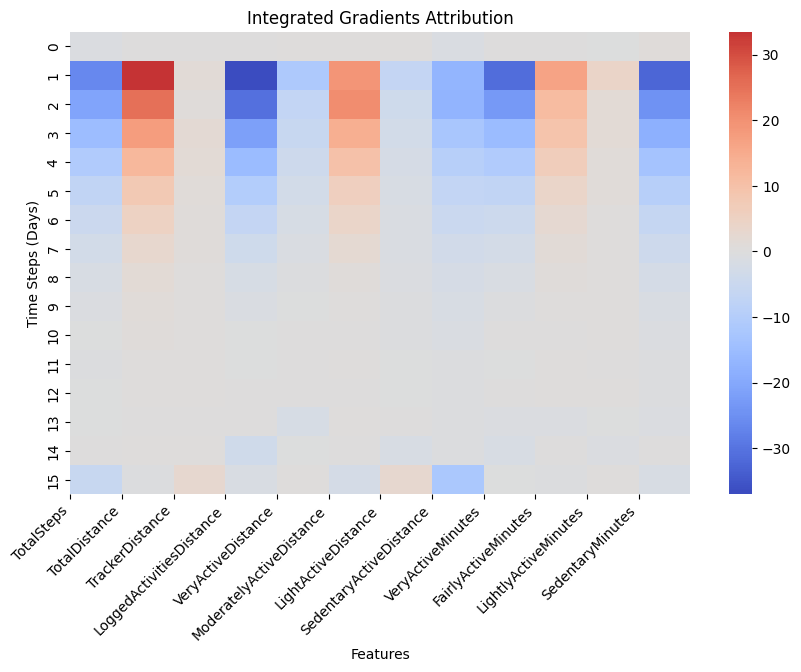

In [4]:

# Visualization of IG for Recurrent Features
plot_feature_importance(IG_recurrent, feature_columns[:-1])